In [253]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
sns.set()

from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

In [57]:
sim_metadata_fold = "../../../data/carla_sim/random_spawn/"
sim_responses_fold = "../../../data/experiments/carla_sim/random_spawn/"

samples = os.listdir(sim_metadata_fold)

In [58]:
samples

['example_0',
 'example_1',
 'example_10',
 'example_100',
 'example_101',
 'example_102',
 'example_103',
 'example_104',
 'example_105',
 'example_106',
 'example_107',
 'example_108',
 'example_109',
 'example_11',
 'example_110',
 'example_111',
 'example_112',
 'example_113',
 'example_114',
 'example_27',
 'example_28',
 'example_29',
 'example_3',
 'example_30',
 'example_31',
 'example_32',
 'example_33',
 'example_34',
 'example_35',
 'example_36',
 'example_37',
 'example_38',
 'example_39',
 'example_4',
 'example_40',
 'example_41',
 'example_42',
 'example_43',
 'example_45',
 'example_46',
 'example_47',
 'example_48',
 'example_49',
 'example_5',
 'example_50',
 'example_51',
 'example_52',
 'example_53',
 'example_54',
 'example_55',
 'example_56',
 'example_57',
 'example_58',
 'example_59',
 'example_6',
 'example_60',
 'example_61',
 'example_63',
 'example_64',
 'example_65',
 'example_66',
 'example_67',
 'example_68',
 'example_69',
 'example_7',
 'example_70',
 '

In [59]:
df_metadata = pd.DataFrame(columns=["sample_id", "coll_type", "t_end", "vel", "diameter", "dt"])

for sample in samples:
    smd = np.load(sim_metadata_fold + sample + "/sim_data.npz", allow_pickle=True)
    df_metadata = pd.concat(
        [
            df_metadata,
            pd.DataFrame(
                {
                    "sample_id": sample.split("_")[1],
                    "coll_type": [smd["coll_type"][()]],
                    "t_end": [smd["t_end"][()]],
                    "vel": [smd["vel"][()]],
                    "diameter": [smd["diameter_object"][()]],
                    "dt": [smd["dt"][()]],
                }
            ),
        ], ignore_index=True
    )

df_metadata['coll_type'].replace(to_replace=[None], value='none', inplace=True)

/tmp/ipykernel_3965/2689157384.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metadata = pd.concat(


In [7]:
df_metadata

,sample_id,coll_type,coll_time,t_end,vel,diameter,dt
0,0,cars,2429,2429,4.529172,2.612508,10.0
1,1,pedestrians,1659,1659,7.947197,0.889352,10.0
2,10,none,4000,4000,7.946603,NaN,10.0
3,100,pedestrians,1659,1659,7.947036,0.929854,10.0
4,101,cars,1399,1399,7.945492,2.727977,10.0
...,...,...,...,...,...,...,...
128,21,none,4009,4009,6.572920,NaN,10.0
129,22,cars,1499,1499,7.947430,2.826570,10.0
130,23,none,4009,4009,7.946305,NaN,10.0
131,24,none,4009,4009,6.994802,NaN,10.0


In [60]:
#models = ["EMD"]#["LGMD", "EMD"]
#models = ["LGMD"]
models = ["EMD"]
tiles = [3]

N_SUBSAMPLE = 5

tile_id_range_y = {3: (1,1), 5: (1,2,3), 7: (2,3,4)}

df_responses = pd.DataFrame(
    columns=[
        "sample_id",
        "model",
        "n tiles",
        "tile_idx_y",
        "tile_idx_x",
        "coll_type",
        "coll_time",
        "vel",
        "diameter",
        "voltage",
        "time",
    ]
)

for model in models:
    print(model)
    for ntile in tiles:
        print(ntile)
        for sample in samples:
            try:
                sample_id = sample.split("_")[1]
                sample_metadata = df_metadata[df_metadata["sample_id"] == sample_id].iloc[0]
                smd = np.load(os.path.join(sim_responses_fold, model, str(ntile) + "_tiles", sample + ".npz"))

                time_ax = (np.arange(smd["v_out"].shape[2]) - (sample_metadata["t_end"]/sample_metadata["dt"]).astype(int)) * sample_metadata["dt"]
                voltage = smd["v_out"]

                for idx_x in range(ntile):
                    for idx_y in tile_id_range_y[ntile]:
                        df_responses = pd.concat([df_responses, pd.DataFrame({
                            "sample_id": sample_id,
                            "model": model,
                            "n tiles": ntile,
                            "tile_idx_x": idx_x,
                            "tile_idx_y": idx_y,
                            "coll_type": sample_metadata["coll_type"],
                            "coll_time": sample_metadata["t_end"],
                            "vel": sample_metadata["vel"],
                            "diameter": sample_metadata["diameter"],
                            "voltage": voltage[idx_y, idx_x],
                            "time": time_ax#(((sample_metadata["dt"] * np.arange(smd["v_out"].shape[2]) - sample_metadata["t_end"]))/T_SUBSAMPLE).astype(int) * T_SUBSAMPLE,
                        })], ignore_index=True)

            except OSError as e:
                #print("could not find file")
                pass

time_ax = np.sort(df_responses["time"].unique())
time_ax_subsample = time_ax[::N_SUBSAMPLE]

df_responses = df_responses[df_responses["time"].isin(time_ax_subsample)]
df_responses = df_responses[df_responses["time"] <= 0.0]

EMD
3


/tmp/ipykernel_3965/2115313771.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_responses = pd.concat([df_responses, pd.DataFrame({


In [122]:
df_responses['time'] = pd.to_numeric(df_responses['time'])
df_responses["n tiles"] = pd.to_numeric(df_responses["n tiles"])
df_responses["coll_time"] = pd.to_numeric(df_responses["coll_time"])
df_responses["voltage"] = pd.to_numeric(df_responses["voltage"]).astype(float)
df_responses["Output Voltage"] = df_responses["voltage"]
df_responses['L/v'] = df_responses['diameter'] / df_responses['vel']
df_responses['Collision Type'] = df_responses['coll_type'].map({'none': 'No Collision', 'cars': 'Cars', 'pedestrians': 'Pedestrians'})

In [139]:
df_responses.to_csv(os.path.join(sim_responses_fold, "responses.csv"))

In [158]:
df_responses[df_responses["L/v"] > 1.]["sample_id"].unique()

array(['40', '193', '194'], dtype=object)

In [1]:
df_responses = pd.read_csv(os.path.join(sim_responses_fold, "responses.csv"))

NameError: name 'pd' is not defined

In [137]:
df_responses.groupby(["coll_type"])["sample_id"].nunique()

coll_type
cars           79
none           89
pedestrians    89
Name: sample_id, dtype: int64

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

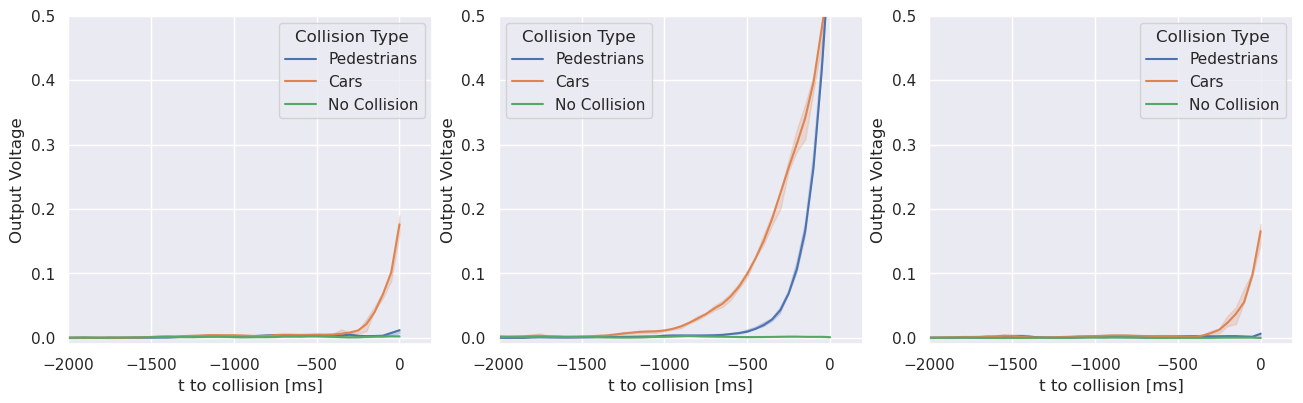

In [124]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3) & (df_responses["model"] == "EMD")
]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1)
    ]
    sns.lineplot(
        x="time",
        y="Output Voltage",
        #estimator=None,#"mean",
        #units="sample_id",
        data=_df_temp,
        sort=True,
        #errorbar="se",
        orient="x",
        hue="Collision Type",
        n_boot=5,
        ax=_ax
    )
    _ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

    _ax.set_ylim(top=0.5, bottom=-0.01)

fig.tight_layout(pad=0.5)

fig.savefig("responses_emd_3_tile.png", dpi=400)
fig.savefig("responses_emd_3_tile.pdf")

plt.show()

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

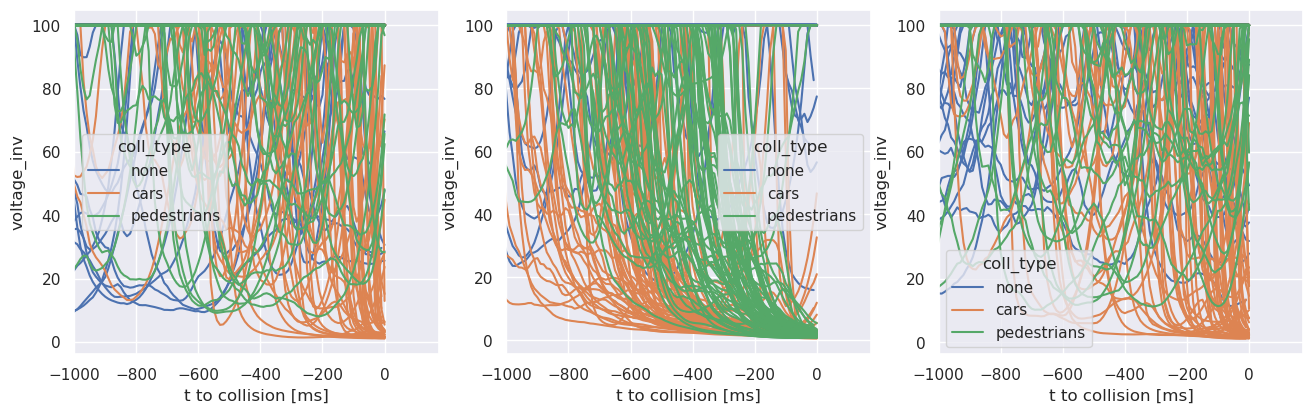

In [55]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3) & (df_responses["model"] == "EMD")
]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1)
    ]
    sns.lineplot(
        x="time",
        y="voltage_inv",
        estimator=None,#"mean",
        units="sample_id",
        data=_df_temp,
        sort=True,
        #errorbar="se",
        orient="x",
        hue="coll_type",
        n_boot=5,
        ax=_ax
    )
    _ax.set_xlim(left=-1000)
    _ax.set_xlabel("t to collision [ms]")

    #_ax.set_ylim(top=0.5, bottom=-0.01)

    #_ax.set_yscale("log")
    #_ax.set_xscale("log")

fig.tight_layout(pad=0.2)

fig.savefig("responses_emd_3_tile_log.png", dpi=400)
fig.savefig("responses_emd_3_tile_log.pdf")

plt.show()

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_

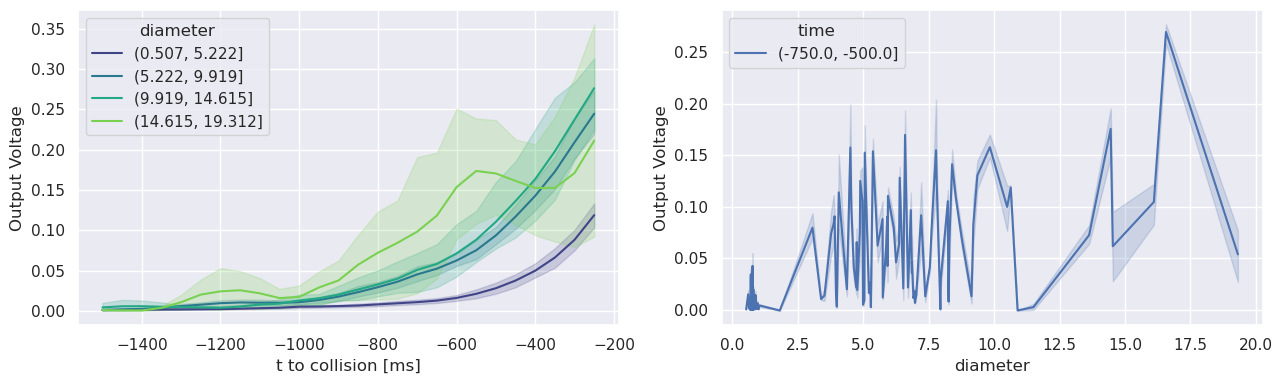

In [252]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3)
    & (df_responses["model"] == "EMD")
    & (df_responses["coll_type"] != "none")
]

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

_df_temp = df_responses_filt[
    (df_responses_filt["tile_idx_x"] == 1)
    & (df_responses_filt["tile_idx_y"] == 1)
    & (df_responses_filt["L/v"] < 1.0)
    & (df_responses_filt.time >= -1500)
    & (df_responses_filt.time <= -250)
]
sns.lineplot(
    x="time",
    y="Output Voltage",
    # estimator="mean",
    data=_df_temp,
    sort=True,
    orient="x",
    hue=pd.cut(_df_temp["diameter"]**2., bins=4),
    palette="viridis",
    ax=ax[0],
    n_boot=100,
)
#ax[0].set_xlim(left=-2000)
ax[0].set_xlabel("t to collision [ms]")

sns.lineplot(
    # x=_df_temp["L/v"] * _df_temp["diameter"] / (-_df_temp["time"] * _df_temp["vel"]),
    x=_df_temp["diameter"]**2.,
    y=_df_temp["Output Voltage"],
    # data=_df_temp[(_df_temp.time >= -750) & (_df_temp.time <= -250)],
    sort=True,
    orient="x",
    hue=pd.cut(_df_temp.time, bins=pd.IntervalIndex.from_tuples([(-750.,-500.)])),
    # palette="viridis",
    ax=ax[1],
    n_boot=100,
)

fig.tight_layout()

fig.savefig("l_v_responses_emd_3_tile.png", dpi=400)
fig.savefig("l_v_responses_emd_3_tile.pdf")

plt.show()

In [200]:
df_responses.groupby(["coll_type"])["L/v"].mean()

coll_type
cars           0.320197
none                NaN
pedestrians    0.150485
Name: L/v, dtype: float64

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

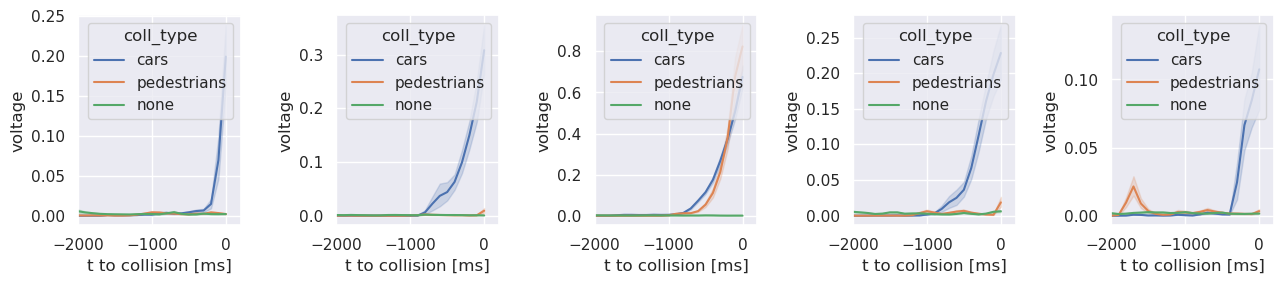

In [94]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 5) & (df_responses["model"] == "EMD")
]

fig, ax = plt.subplots(1, 5, figsize=(13, 3))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 2)
    ]
    sns.lineplot(
        x="time",
        y="voltage",
        estimator="mean",
        data=_df_temp,
        sort=True,
        orient="x",
        hue="coll_type",
        ax=_ax
    )
    _ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

fig.tight_layout()

fig.savefig("responses_emd_5_tile.png", dpi=400)

plt.show()

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

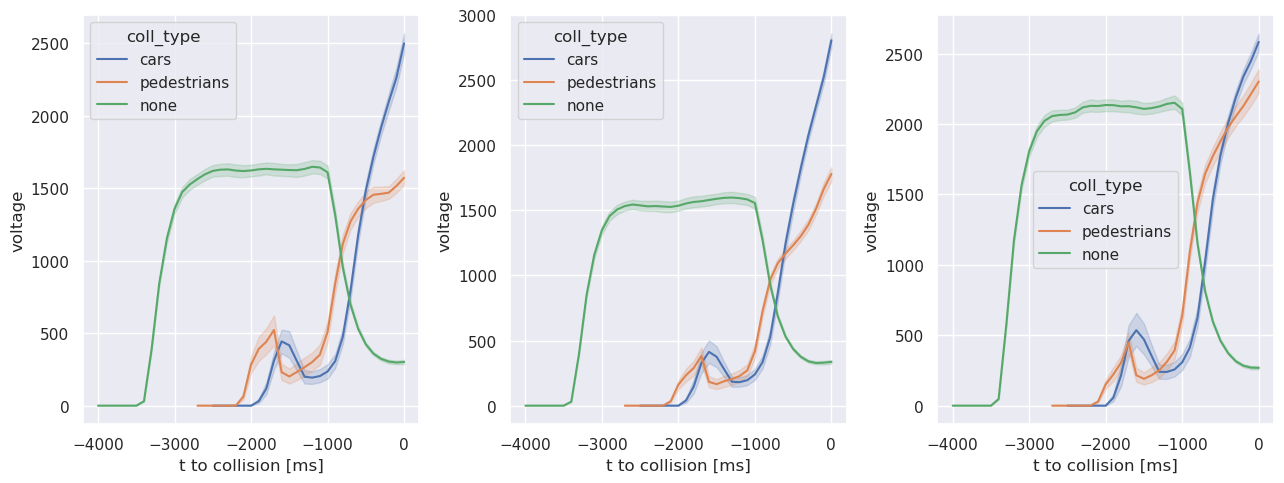

In [119]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3) & (df_responses["model"] == "LGMD")
]

fig, ax = plt.subplots(1, 3, figsize=(13, 5))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1)
    ]
    sns.lineplot(
        x="time",
        y="voltage",
        estimator="mean",
        data=_df_temp,
        sort=True,
        orient="x",
        hue="coll_type",
        ax=_ax
    )
    #_ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

fig.tight_layout()

fig.savefig("responses_lgmd_3_tile.png", dpi=400)

plt.show()

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

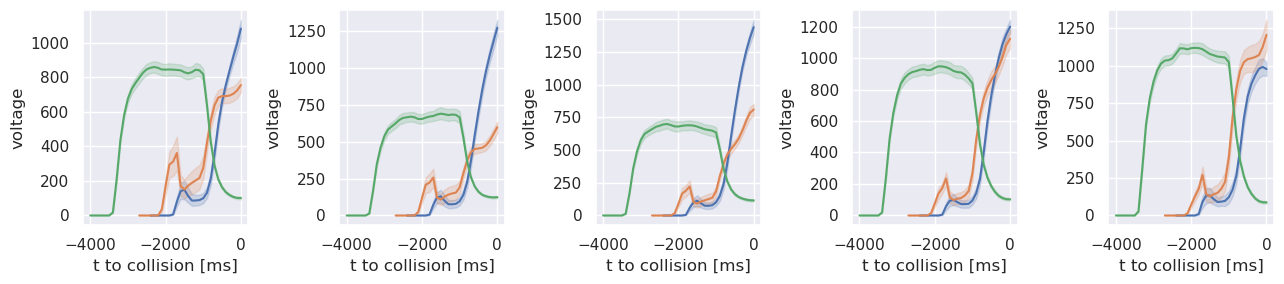

In [101]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 5) & (df_responses["model"] == "LGMD")
]

fig, ax = plt.subplots(1, 5, figsize=(13, 3))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 2)
    ]
    sns.lineplot(
        x="time",
        y="voltage",
        estimator="mean",
        data=_df_temp,
        sort=True,
        orient="x",
        hue="coll_type",
        ax=_ax,
        legend=False
    )
    #_ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

fig.tight_layout()

fig.savefig("responses_lgmd_5_tile.png", dpi=400)

plt.show()

In [104]:
df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    & (df_responses["tile_idx_x"] == 1)
]

,sample_id,model,n tiles,tile_idx_y,tile_idx_x,coll_type,coll_time,vel,diameter,voltage,time,L/v
1016508,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2400,0.576818
1016509,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2400,0.576818
1016510,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2400,0.576818
1016511,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2300,0.576818
1016512,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2300,0.576818
...,...,...,...,...,...,...,...,...,...,...,...,...
1160361,90,EMD,3,1,1,none,4009,7.947014,NaN,0.003490,0,NaN
1160362,90,EMD,3,1,1,none,4009,7.947014,NaN,0.003186,0,NaN
1160363,90,EMD,3,1,1,none,4009,7.947014,NaN,0.003138,0,NaN
1160364,90,EMD,3,1,1,none,4009,7.947014,NaN,0.003515,0,NaN


In [269]:
df_emd = df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    & (df_responses["tile_idx_x"] == 1)
].copy()

#df_emd["voltage"] += np.random.normal(0, 0.05, len(df_emd))

df_emd["positive"] = df_emd["coll_type"] != "none"
#df_emd.loc[df_emd["coll_type"] == "none", "time"] += 2500.0

n_sweep = 20

min_react_time = np.linspace(0.0, 1500.0, n_sweep)

roc_car = []
roc_pedestrian = []
aupr_car = []
aupr_pedestrian = []

roc_curve_sweep_car = []
roc_curve_sweep_pedestrian = []

pr_curve_sweep_car = []
pr_curve_sweep_pedestrian = []

for t in min_react_time:
    _df_car = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2000.)) & (df_emd["coll_type"] != "pedestrians")
    ].copy()

    _df_pedestrian = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2000.)) & (df_emd["coll_type"] != "cars")
    ].copy()

    df_emd_max_resp_car = (
        _df_car.groupby(["sample_id", "positive"]).max().reset_index()
    )

    df_emd_max_resp_pedestrian = (
        _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc_car.append(roc_auc_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["voltage"]))
    aupr_car.append(average_precision_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["voltage"]))
    roc_curve_sweep_car.append(
        roc_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["voltage"])
    )

    roc_pedestrian.append(roc_auc_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["voltage"]))
    aupr_pedestrian.append(average_precision_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["voltage"]))
    roc_curve_sweep_pedestrian.append(
        roc_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["voltage"])
    )

    pr_curve_sweep_car.append(
        precision_recall_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["voltage"])
    )
    pr_curve_sweep_pedestrian.append(
        precision_recall_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["voltage"])
    )

/tmp/ipykernel_3965/3613121957.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pr = pd.concat(
/tmp/ipykernel_3965/3613121957.py:74: RuntimeWarning: invalid value encountered in divide
  "f1": 2 * pr[0][1:] * pr[1][1:] / (pr[0][1:] + pr[1][1:]),
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


ValueError: cannot reindex on an axis with duplicate labels

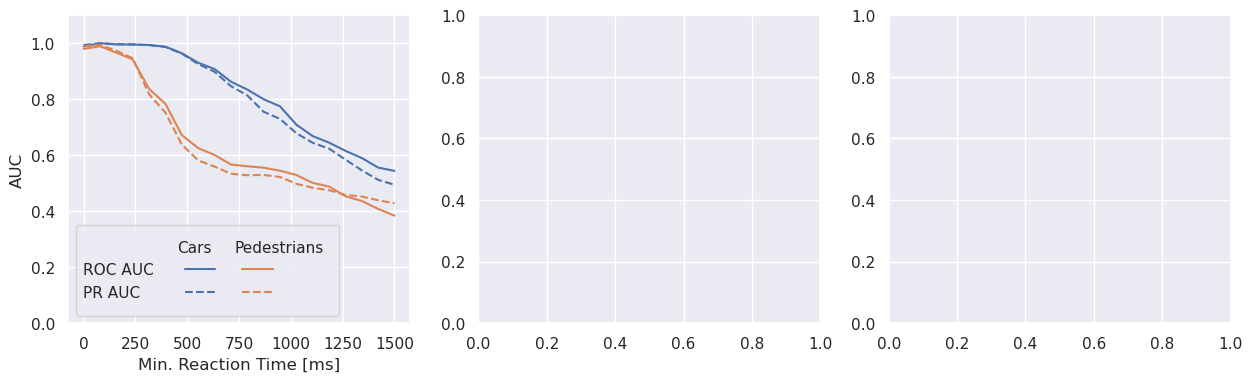

In [282]:
import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="ROC AUC"),
    m_patches.Patch(color="none", label="PR AUC"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Pedestrians")]

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

c_roc = ax[0].plot(min_react_time, roc_car, "-", c=colors[0], label="*")
c_aupr = ax[0].plot(min_react_time, aupr_car, "--", c=colors[0], label="*")
patches_column2.extend([c_roc[0], c_aupr[0]])
p_roc = ax[0].plot(min_react_time, roc_pedestrian, "-", c=colors[1], label="*")
p_aupr = ax[0].plot(min_react_time, aupr_pedestrian, "--", c=colors[1], label="*")
patches_column3.extend([p_roc[0], p_aupr[0]])

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

ax[0].set_ylim(top=1.1, bottom=0.0)

ax[0].set_ylabel("AUC")
ax[0].set_xlabel("Min. Reaction Time [ms]")
lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")

cmap = plt.get_cmap("viridis")

df_pr = pd.DataFrame(columns=["recall", "precision", "model", "min_react_time", "coll_type", "f1", "threshold"])
for i, pr in enumerate(pr_curve_sweep_car):
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "min_react_time": min_react_time[i],
                    "coll_type": "cars",
                    "f1": 2 * pr[0][1:] * pr[1][1:] / (pr[0][1:] + pr[1][1:]),
                    "threshold": pr[2],
                }
            ),
        ], ignore_index=True
    )

for i, pr in enumerate(pr_curve_sweep_pedestrian):
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "min_react_time": min_react_time[i],
                    "coll_type": "pedestrians",
                    "f1": 2 * pr[0][1:] * pr[1][1:] / (pr[0][1:] + pr[1][1:]),
                    "threshold": pr[2],
                }
            ),
        ]
    )

#sns.lineplot(x="threshold", y="f1", data=df_pr[df_pr.coll_type=="cars"], ax=ax[1], estimator=None, hue="min_react_time", palette="viridis")

sns.lineplot(x="threshold", y="f1", data=df_pr[df_pr.coll_type=="pedestrians"], ax=ax[2], hue="min_react_time", palette="viridis") 

#ax[1].set_xlim(right=0.2)

fig.tight_layout()
fig.savefig("roc_pr_emd.png", dpi=400)
fig.savefig("roc_pr_emd.pdf")
plt.show()

In [283]:
df_pr

,recall,precision,model,min_react_time,coll_type,f1,threshold
0,1.000000,0.473054,EMD,0.0,cars,0.642276,-0.000532
1,1.000000,0.475904,EMD,0.0,cars,0.644898,-0.000481
2,1.000000,0.478788,EMD,0.0,cars,0.647541,-0.000366
3,1.000000,0.481707,EMD,0.0,cars,0.650206,-0.000345
4,1.000000,0.484663,EMD,0.0,cars,0.652893,-0.000301
...,...,...,...,...,...,...,...
143,0.011628,0.250000,EMD,1500.0,pedestrians,0.022222,0.022259
144,0.011628,0.333333,EMD,1500.0,pedestrians,0.022472,0.023602
145,0.011628,0.500000,EMD,1500.0,pedestrians,0.022727,0.044869
146,0.000000,0.000000,EMD,1500.0,pedestrians,NaN,0.057550


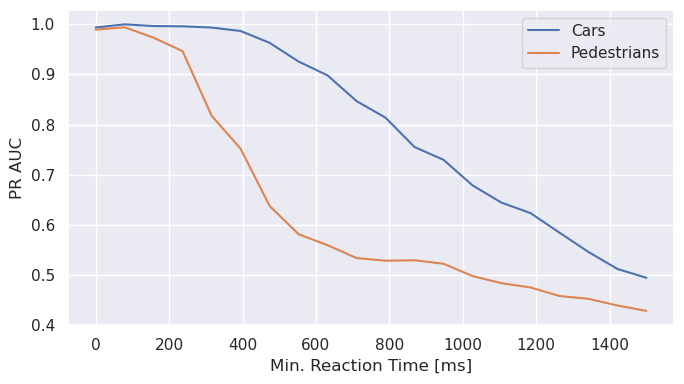

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.plot(min_react_time, aupr_car, label="Cars")
ax.plot(min_react_time, aupr_pedestrian, label="Pedestrians")
ax.set_ylabel("PR AUC")
ax.set_xlabel("Min. Reaction Time [ms]")
ax.legend()

fig.tight_layout()
fig.savefig("roc_emd.png", dpi=400)
plt.show()

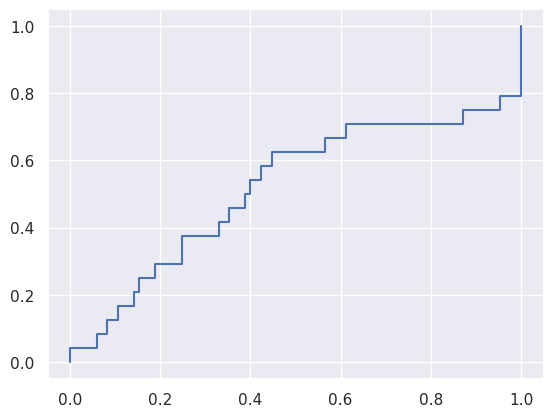

In [41]:
plt.plot(roc_curve_sweep[-8][0], roc_curve_sweep[-8][1])
plt.show()

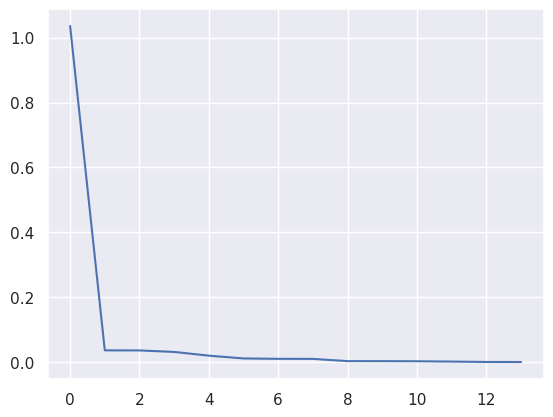

In [113]:
plt.plot(roc_curve_sweep[15][2])
plt.show()